In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [20]:
!nvidia-smi

Thu Feb 27 16:11:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8              6W /   60W |     177MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Few points to be noted:  
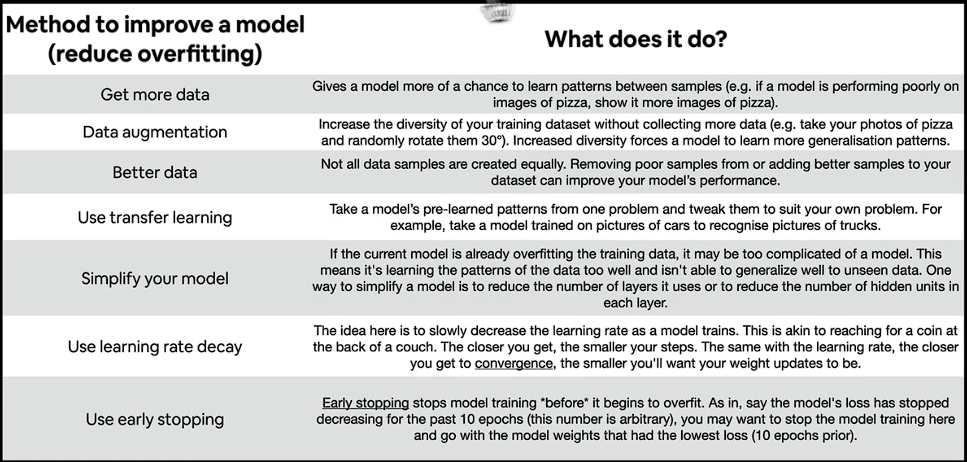

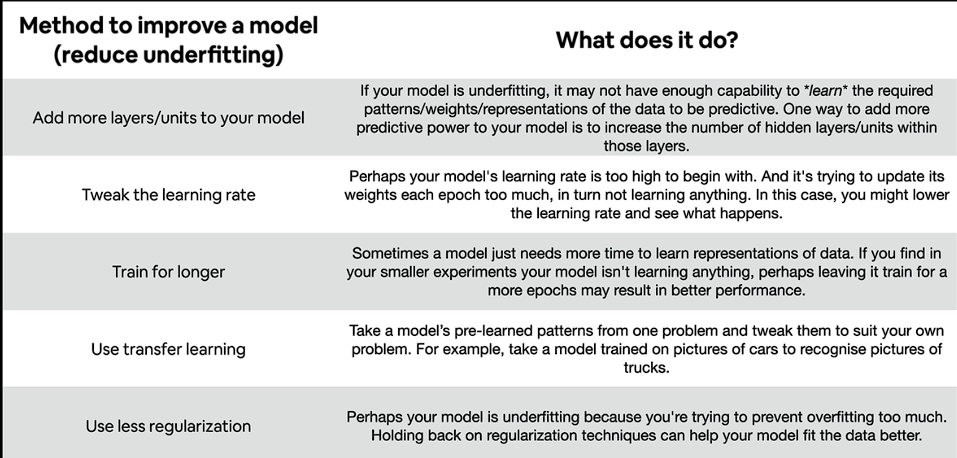

In [22]:
data_transform0 = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64,64)),
    # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    transforms.ToTensor()
])

#### Model_0

Tiny VGG with simple dataset [no tranformation]

In [23]:
train_dir = f'../dataset/MiniFood101/train'
test_dir = f'../dataset/MiniFood101/test'

train_data0 = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform0,
                                  target_transform=None)

test_data0 = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform0,
                                 target_transform=None)

train_data0,test_data0

(Dataset ImageFolder
     Number of datapoints: 7575
     Root location: ../dataset/MiniFood101/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2525
     Root location: ../dataset/MiniFood101/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [24]:
WORKERS = 1
BATCH_SIZE = 25

train_dataloader0 = DataLoader(dataset=train_data0,
                              batch_size=BATCH_SIZE,
                              num_workers=WORKERS,
                              shuffle=True)

test_dataloader0 = DataLoader(dataset=test_data0,
                             batch_size=BATCH_SIZE,
                             num_workers=WORKERS,
                             shuffle=False)

In [25]:
class_names = train_data0.classes

We will use Tiny-VGG CNN model to help with the classification

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape:int,
                 hidden_units:int,
                 output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.linear_stack = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=16*16*30,out_features=output_shape)
        )
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        # print("Shape After conv_block_1", x.shape)
        x = self.conv_block_2(x)
        # print("Shape After conv_block_2", x.shape)
        return self.linear_stack(x)

In [27]:
model_0 = TinyVGG(input_shape=3,
                  hidden_units=30,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7680, out_features=101, bias=True)
    (2): ReLU()
  )
)

In [28]:
image,label = next(iter(train_dataloader0))
image.shape,label

(torch.Size([25, 3, 64, 64]),
 tensor([54, 82, 18, 29, 26, 74, 60, 71, 79, 74, 30, 36, 74, 64, 56, 63, 86,  5,
         16, 12, 72, 49, 15, 27, 84]))

In [29]:
image = image.to(device)
model_0(image)

tensor([[0.0000, 0.0296, 0.0000,  ..., 0.0000, 0.0000, 0.0318],
        [0.0000, 0.0300, 0.0000,  ..., 0.0000, 0.0000, 0.0401],
        [0.0000, 0.0276, 0.0000,  ..., 0.0000, 0.0000, 0.0400],
        ...,
        [0.0000, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0407],
        [0.0000, 0.0323, 0.0000,  ..., 0.0000, 0.0000, 0.0394],
        [0.0000, 0.0314, 0.0000,  ..., 0.0000, 0.0000, 0.0331]],
       device='cuda:0', grad_fn=<ReluBackward0>)

In [30]:
from torchinfo import summary 

summary(model_0,input_size=[3,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [3, 101]                  --
├─Sequential: 1-1                        [3, 30, 32, 32]           --
│    └─Conv2d: 2-1                       [3, 30, 64, 64]           840
│    └─ReLU: 2-2                         [3, 30, 64, 64]           --
│    └─Conv2d: 2-3                       [3, 30, 64, 64]           8,130
│    └─ReLU: 2-4                         [3, 30, 64, 64]           --
│    └─MaxPool2d: 2-5                    [3, 30, 32, 32]           --
├─Sequential: 1-2                        [3, 30, 16, 16]           --
│    └─Conv2d: 2-6                       [3, 30, 32, 32]           8,130
│    └─ReLU: 2-7                         [3, 30, 32, 32]           --
│    └─Conv2d: 2-8                       [3, 30, 32, 32]           8,130
│    └─ReLU: 2-9                         [3, 30, 32, 32]           --
│    └─MaxPool2d: 2-10                   [3, 30, 16, 16]           --
├─Seq

In [23]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    accuracy = (correct/len(y_pred)) * 100
    return accuracy

In [ ]:
from tqdm.auto import tqdm

def training_step(model: nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: nn.Module,
                  optimizer: torch.optim.Optimizer,
                  epoch: int,
                  device: torch.device = device,) -> list[int]:
    ''' 
        Performs training step on the model.
    '''
    
    acc_train = 0
    loss_train = 0
    model.train()

    for X,y in tqdm(data_loader, desc=f"Epoch {epoch} Training", leave=False):

        X,y = X.to(device),y.to(device)
        
        y_pred_logits = model(X)
        # print(y_pred_logits.shape)
        y_pred = torch.argmax(y_pred_logits,dim=1)
        # print(y_pred.shape)

        loss = loss_fn(y_pred_logits,y)
        loss_train += loss.item()
        acc_train += accuracy_fn(y,y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return loss_train,acc_train

In [ ]:
from tqdm.auto import tqdm

store_y = []

def testing_step(model: nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: nn.Module,
                  epoch: int,
                  device: torch.device = device,) -> list[int]:
    ''' 
        Performs testing step on the model.
    '''
    acc_test = 0
    loss_test = 0

    model.eval()

    with torch.inference_mode():
        for X,y in tqdm(data_loader, desc=f"Epoch {epoch} Testing", leave=False):
            X,y = X.to(device),y.to(device)

            y_pred_logits = model(X)
            y_pred = torch.argmax(y_pred_logits,dim=1)

            store_y.append(y_pred)

            loss_test += loss_fn(y_pred_logits,y).item()
            acc_test += accuracy_fn(y,y_pred)
    
    return loss_test,acc_test


In [ ]:
loss_fn0 = nn.CrossEntropyLoss().to(device)
optimizer0 = torch.optim.Adam(params=model_0.parameters(),lr=0.001)
scheduler0 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer0, mode='min', factor=0.5, patience=3)

In [19]:
from typing import Dict,List

def initiate_training(model: nn.Module,
                      train_dataloader: torch.utils.data.DataLoader,
                      test_dataloader: torch.utils.data.DataLoader,
                      optimizer: torch.optim.Optimizer,
                      loss_fn: nn.Module,
                    #   scheduler: torch.optim.lr_scheduler._LRScheduler | None=None,
                      epochs: int=5,
                      device=device) -> Dict[str,List[int]]:
    
    results = {
                "train_loss": [],
                "test_loss": [],
                "train_acc": [],
                "test_acc": [],
                "epoch_count": [i for i in range(1, epochs+1)]
               }
    
    for epoch in range(epochs):
        # Training
        loss_train,acc_train = training_step(model=model,
                                            data_loader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            epoch=epoch,
                                            device=device) 
        
        epoch_train_loss = loss_train / len(train_dataloader)
        epoch_train_acc = acc_train / len(train_dataloader)
        results['train_loss'].append(epoch_train_loss)
        results['train_acc'].append(epoch_train_acc)

        # Testing
        loss_test,acc_test = testing_step(model=model,
                                        data_loader=test_dataloader,
                                        loss_fn=loss_fn,
                                        epoch=epoch,
                                        device=device)
            
        epoch_test_loss = loss_test / len(test_dataloader)
        epoch_test_acc = acc_test / len(test_dataloader)
        results['test_loss'].append(epoch_test_loss)
        results['test_acc'].append(epoch_test_acc)
        
        # scheduler.step(epoch_test_loss)
        # Print final metrics for the epoch
        print(f"Epoch {epoch}: Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f} | Train Accuracy: {epoch_train_acc:.4f} | Test Accuracy: {epoch_test_acc:.4f}")

    return results

    

In [ ]:
import time
from tqdm.auto import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

print("Training Model-0")
start_time = time.time()

results_model_0 = initiate_training(model=model_0,
                            train_dataloader=train_dataloader0,
                            test_dataloader=test_dataloader0,
                            optimizer=optimizer0,
                            # scheduler=scheduler0,
                            loss_fn=loss_fn0,
                            epochs=epochs,
                            device=device)

end_time = time.time()

model_0_training_time = end_time-start_time

Training Model-0


Epoch 0: Train Loss: 4.6154 | Test Loss: 4.6151 | Train Accuracy: 0.9637 | Test Accuracy: 0.9901


Epoch 1: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 2: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 3: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 4: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 5: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 6: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 7: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 8: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 9: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 10: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 11: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 12: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 13: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 14: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 15: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 16: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 17: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 18: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 19: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 20: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 21: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 22: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 23: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 24: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 25: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 26: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 27: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 28: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 29: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 30: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 31: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 32: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 33: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 34: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 35: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 36: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 37: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 38: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 39: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 40: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 41: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 42: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 43: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 44: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 45: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 46: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 47: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 48: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 49: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 50: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 51: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 52: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 53: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 54: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 55: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 56: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 57: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 58: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 59: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 60: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 61: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 62: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 63: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 64: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 65: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 66: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 67: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 68: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 69: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 70: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 71: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 72: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 73: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 74: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 75: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 76: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 77: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 78: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 79: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 80: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 81: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 82: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 83: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 84: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 85: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 86: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 87: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 88: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 89: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 90: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 91: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 92: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 93: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 94: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 95: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 96: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 97: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 98: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


Epoch 99: Train Loss: 4.6151 | Test Loss: 4.6151 | Train Accuracy: 0.9901 | Test Accuracy: 0.9901


In [ ]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
    
    # Testing
    loss_test,acc_test = testing_step(model=model,
                                      data_loader=data_loader,
                                      loss_fn=loss_fn,
                                      epoch=epochs,
                                      device=device)
        
    loss_final = loss_test/len(data_loader)
    acc = acc_test/len(data_loader)
    
    return {
        "model_name": model.__class__.__name__, 
        "model_loss": loss_final,
        "model_acc": acc
    }

model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader0,
                             loss_fn=loss_fn0)
model_0_results

Function to plot Train/Test Loss and Accuracy w.r.t epochs while training.

In [30]:
import matplotlib.pyplot as plt
def plot_model_lossacc(results: Dict[str,List[int]]):
    ''' 
    Plots Loss and Accuracy curves w.r.t epoch.
    '''

    train_loss = results['train_loss']
    test_loss = results['test_loss']

    train_acc = results['train_acc']
    test_acc = results['test_acc']

    epochs = results['epoch_count']

    plt.figure(figsize=(15,7))

    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="Train Loss")
    plt.plot(epochs,test_loss,label="Test Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs,train_acc,label="Train Accuracy")
    plt.plot(epochs,test_acc,label="Test Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

# plot_model_lossacc(results_model_0)

#### Model_1

Tiny VGGV1 with 4 Conv blocks and 10 hidden units

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
train_transform1 = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random crop & resize
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images
    transforms.RandomRotation(15),  # Rotate images
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Color adjustments
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Rotation & shift
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Perspective distortion
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Apply blur
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform1 = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#### 1. Creating transform.py file 

In [38]:
%%writefile ../src/transform.py

from torchvision import transforms

train_transform1 = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random crop & resize
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images
    transforms.RandomRotation(15),  # Rotate images
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Color adjustments
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Rotation & shift
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Perspective distortion
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Apply blur
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform1 = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

Writing ../src/transform.py


In [73]:
train_dir = f'../dataset/MiniFood101/train'
test_dir = f'../dataset/MiniFood101/test'

train_data1 = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform1,
                                  target_transform=None)

test_data1 = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform1,
                                 target_transform=None)

class_names = train_data1.classes

train_data1,test_data1

(Dataset ImageFolder
     Number of datapoints: 7575
     Root location: ../dataset/MiniFood101/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.1, 0.1))
                RandomAffine(degrees=[-15.0, 15.0], translate=(0.1, 0.1))
                RandomPerspective(p=0.5)
                GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 2525
     Root location: ../dataset/MiniFood101/test
     StandardTransform
 Transform: Compose(
                Resize(size=(1

In [5]:
WORKERS = 1
BATCH_SIZE = 25

train_dataloader1 = DataLoader(dataset=train_data1,
                              batch_size=BATCH_SIZE,
                              num_workers=WORKERS,
                              shuffle=True)

test_dataloader1 = DataLoader(dataset=test_data1,
                             batch_size=BATCH_SIZE,
                             num_workers=WORKERS,
                             shuffle=False)

#### 2. Creating data_setup.py for creating PyTorch DataLoaders

In [6]:
%%writefile ../src/data_setup.py
''' 
Contains functionality for creating Pytorch DataLoader, for image classification
'''

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_dataloaders(train_dir: str,
                       test_dir: str,
                       train_transform: transforms.Compose,
                       test_transform: transforms.Compose,
                       batch_size:int,
                       num_workers: int = 1):
    ''' 
    Creates training and testing DataLoaders
    
    Takes in training and testing directory paths and turns 
    them into PyTorch Datasets and into Pytorch DataLoaders

    Args:
        train_dir: Path to Training Directory.
        test_dir: Path to Testing Directory.
        tranform: torchvision tranform to perform 
                  tranformation on train and test dataset.
        batch_size: Number of samples per batch in each of 
                    the DataLoaders. 
        num_workers: number of logical processors
                     per DataLoader.
    
    Returns:
        A tuple of (train_dataloader, test_dataloader, class_names)
    '''

    train_data = datasets.ImageFolder(train_dir,
                                        transform=train_transform)
    test_data = datasets.ImageFolder(test_dir,
                                        transform=test_transform)
    
    class_names = train_data.classes

    train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)   # pin_memory enables fast data transfer to CUDA-enabled GPUs

    test_dataloader = DataLoader(dataset=test_data,
                                batch_size=batch_size,
                                num_workers=num_workers,
                                shuffle=False,
                                pin_memory=True)

    return train_dataloader,test_dataloader, class_names


Overwriting ../src/data_setup.py


Testing data_setup.py

In [ ]:
import os
import sys

# Get the parent directory (where `src` is located)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import src
from src.data_setup import create_dataloaders

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    train_transform=train_transform1,
                                                                    test_transform=test_transform1,
                                                                    batch_size=25,
                                                                    num_workers=1)

img,label = next(iter(train_dataloader))
print(img,label)

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9608, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.6235, -0.5765, -0.6000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.4667, -0.4196, -0.4431,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7020, -0.4824, -0.4196,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9608, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.6314, -0.5765, -0.6000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.4745, -0.4196, -0.4353,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7020, -0.4902, -0.4118,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -

Creating Model TinyVGGV1 

In [25]:
class TinyVGGV1(nn.Module):
    def __init__(self,
                 input_shape:int,
                 hidden_units:int,
                 output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.linear_stack = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=8*8*20,out_features=128),
            nn.ELU(),
            nn.Dropout(0.3), 
            nn.Linear(in_features=128, out_features=output_shape)
        )
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        # print("Shape After conv_block_1", x.shape)
        x = self.conv_block_2(x)
        # print("Shape After conv_block_2", x.shape)
        x = self.conv_block_3(x)
        # print("Shape After conv_block_3", x.shape)
        x = self.conv_block_4(x)
        # print("Shape After conv_block_3", x.shape)
        return self.linear_stack(x)

In [26]:
model_1 = TinyVGGV1(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)
model_1

TinyVGGV1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ELU(alpha=1.0)
    (8): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(al

#### 3. Creating models.(name)(version).py
    
 where models contains different models built for this problem

In [11]:
%%writefile ../src/models/TinyVGG.py
''' 
    Contains PyTorch model code to instantiate a TinyVGG model
'''
import torch 
from torch import nn

class TinyVGGV1(nn.Module):
    ''' 
        Creates a modified version of TinyVGG architecture.  
        See the original architecture from here: https://poloclub.github.io/cnn-explainer/  

        Args:
            input_shape: Number of input channels.
            hidden_units: Number of hidden neurons per layer/ Number of Hidden Units.
            output_shape: Number of output units

    '''
    def __init__(self,
                 input_shape:int,
                 hidden_units:int,
                 output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ELU(),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.linear_stack = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=8*8*10,out_features=128),
            nn.ELU(),
            nn.Dropout(0.4), 
            nn.Linear(in_features=128, out_features=output_shape)
        )
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        return self.linear_stack(x)


Overwriting ../src/models/TinyVGG.py


Testing the TinyVGG.py script

In [21]:
from src.models.TinyVGG import TinyVGGV1

torch.cuda.manual_seed(42)
modelX = TinyVGGV1(input_shape=3,
                   hidden_units=10,
                   output_shape=len(class_names)).to(device)

In [27]:
loss_fn1 = nn.CrossEntropyLoss().to(device)
optimizer1 = torch.optim.Adam(params=model_1.parameters(),lr=0.001)
# Reduce learning rate if validation loss does not improve for 3 epochs
# scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='min', factor=0.5, patience=3)

TinyVGGV1 Model being train for 200 epochs with 10 hidden units

In [28]:
import time
from tqdm.auto import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 200

print("Training Model-1")
start_time = time.time()

results_model_1 = initiate_training(model=model_1,
                            train_dataloader=train_dataloader1,
                            test_dataloader=test_dataloader1,
                            optimizer=optimizer1,
                            loss_fn=loss_fn1,
                            # scheduler=scheduler1,
                            epochs=epochs,
                            device=device)

end_time = time.time()

model_1_training_time = end_time-start_time

Training Model-1


Epoch 0: Train Loss: 4.7254 | Test Loss: 4.5914 | Train Accuracy: 1.5050 | Test Accuracy: 1.9802


Epoch 1: Train Loss: 4.5956 | Test Loss: 4.5399 | Train Accuracy: 2.3894 | Test Accuracy: 2.2970


Epoch 2: Train Loss: 4.5290 | Test Loss: 4.4436 | Train Accuracy: 2.7063 | Test Accuracy: 3.6832


Epoch 3: Train Loss: 4.4890 | Test Loss: 4.3454 | Train Accuracy: 3.1551 | Test Accuracy: 4.7921


Epoch 4: Train Loss: 4.4548 | Test Loss: 4.3123 | Train Accuracy: 3.6964 | Test Accuracy: 5.2673


Epoch 5: Train Loss: 4.3922 | Test Loss: 4.2812 | Train Accuracy: 4.2376 | Test Accuracy: 5.1881


Epoch 6: Train Loss: 4.3365 | Test Loss: 4.2814 | Train Accuracy: 5.1617 | Test Accuracy: 5.5446


Epoch 7: Train Loss: 4.2827 | Test Loss: 4.1789 | Train Accuracy: 5.3333 | Test Accuracy: 7.3267


Epoch 8: Train Loss: 4.2343 | Test Loss: 4.1856 | Train Accuracy: 6.1122 | Test Accuracy: 6.9307


Epoch 9: Train Loss: 4.1814 | Test Loss: 4.1257 | Train Accuracy: 6.1122 | Test Accuracy: 7.4851


Epoch 10: Train Loss: 4.1655 | Test Loss: 4.0937 | Train Accuracy: 6.3498 | Test Accuracy: 7.8020


Epoch 11: Train Loss: 4.1089 | Test Loss: 4.0549 | Train Accuracy: 7.7228 | Test Accuracy: 8.9109


Epoch 12: Train Loss: 4.0976 | Test Loss: 4.0468 | Train Accuracy: 7.6436 | Test Accuracy: 9.6238


Epoch 13: Train Loss: 4.0531 | Test Loss: 3.9915 | Train Accuracy: 8.6733 | Test Accuracy: 10.4554


Epoch 14: Train Loss: 4.0285 | Test Loss: 3.9462 | Train Accuracy: 8.7129 | Test Accuracy: 10.8119


Epoch 15: Train Loss: 3.9901 | Test Loss: 3.8945 | Train Accuracy: 9.6898 | Test Accuracy: 11.8812


Epoch 16: Train Loss: 3.9799 | Test Loss: 3.9169 | Train Accuracy: 9.5050 | Test Accuracy: 11.3663


Epoch 17: Train Loss: 3.9313 | Test Loss: 3.8733 | Train Accuracy: 10.4422 | Test Accuracy: 11.2079


Epoch 18: Train Loss: 3.9083 | Test Loss: 3.8676 | Train Accuracy: 10.9175 | Test Accuracy: 12.0396


Epoch 19: Train Loss: 3.8654 | Test Loss: 3.8081 | Train Accuracy: 10.9835 | Test Accuracy: 11.9208


Epoch 20: Train Loss: 3.8383 | Test Loss: 3.7723 | Train Accuracy: 11.7228 | Test Accuracy: 13.2277


Epoch 21: Train Loss: 3.8311 | Test Loss: 3.7694 | Train Accuracy: 11.6964 | Test Accuracy: 13.8614


Epoch 22: Train Loss: 3.7737 | Test Loss: 3.7420 | Train Accuracy: 12.7129 | Test Accuracy: 13.7822


Epoch 23: Train Loss: 3.7654 | Test Loss: 3.7075 | Train Accuracy: 13.1089 | Test Accuracy: 14.6139


Epoch 24: Train Loss: 3.7549 | Test Loss: 3.7178 | Train Accuracy: 12.8449 | Test Accuracy: 14.4554


Epoch 25: Train Loss: 3.6934 | Test Loss: 3.6363 | Train Accuracy: 14.2046 | Test Accuracy: 15.8020


Epoch 26: Train Loss: 3.6877 | Test Loss: 3.6303 | Train Accuracy: 14.1386 | Test Accuracy: 16.4752


Epoch 27: Train Loss: 3.6437 | Test Loss: 3.6051 | Train Accuracy: 14.7723 | Test Accuracy: 15.8416


Epoch 28: Train Loss: 3.6200 | Test Loss: 3.6223 | Train Accuracy: 14.5743 | Test Accuracy: 15.5644


Epoch 29: Train Loss: 3.6022 | Test Loss: 3.6322 | Train Accuracy: 14.9571 | Test Accuracy: 16.2376


Epoch 30: Train Loss: 3.5955 | Test Loss: 3.5860 | Train Accuracy: 16.1188 | Test Accuracy: 16.7921


Epoch 31: Train Loss: 3.5610 | Test Loss: 3.5387 | Train Accuracy: 16.3828 | Test Accuracy: 17.9406


Epoch 32: Train Loss: 3.5494 | Test Loss: 3.7204 | Train Accuracy: 16.8581 | Test Accuracy: 14.4950


Epoch 33: Train Loss: 3.4995 | Test Loss: 3.5834 | Train Accuracy: 16.6205 | Test Accuracy: 17.0693


Epoch 34: Train Loss: 3.5011 | Test Loss: 3.5850 | Train Accuracy: 16.5941 | Test Accuracy: 17.5050


Epoch 35: Train Loss: 3.5166 | Test Loss: 3.5128 | Train Accuracy: 16.8581 | Test Accuracy: 18.2178


Epoch 36: Train Loss: 3.4615 | Test Loss: 3.5079 | Train Accuracy: 16.9901 | Test Accuracy: 18.4950


Epoch 37: Train Loss: 3.4498 | Test Loss: 3.4623 | Train Accuracy: 17.8878 | Test Accuracy: 18.2970


Epoch 38: Train Loss: 3.4485 | Test Loss: 3.5215 | Train Accuracy: 17.2805 | Test Accuracy: 17.5050


Epoch 39: Train Loss: 3.4019 | Test Loss: 3.4767 | Train Accuracy: 18.5347 | Test Accuracy: 19.2871


Epoch 40: Train Loss: 3.3793 | Test Loss: 3.4629 | Train Accuracy: 19.0627 | Test Accuracy: 19.6436


Epoch 41: Train Loss: 3.3858 | Test Loss: 3.4367 | Train Accuracy: 19.0891 | Test Accuracy: 20.0792


Epoch 42: Train Loss: 3.3568 | Test Loss: 3.4188 | Train Accuracy: 19.5644 | Test Accuracy: 19.8416


Epoch 43: Train Loss: 3.3592 | Test Loss: 3.4439 | Train Accuracy: 19.3531 | Test Accuracy: 19.8020


Epoch 44: Train Loss: 3.3343 | Test Loss: 3.4574 | Train Accuracy: 19.4983 | Test Accuracy: 19.6832


Epoch 45: Train Loss: 3.3093 | Test Loss: 3.5528 | Train Accuracy: 20.3168 | Test Accuracy: 18.0198


Epoch 46: Train Loss: 3.3036 | Test Loss: 3.4298 | Train Accuracy: 20.6865 | Test Accuracy: 20.0396


Epoch 47: Train Loss: 3.2932 | Test Loss: 3.4335 | Train Accuracy: 20.5281 | Test Accuracy: 19.3663


Epoch 48: Train Loss: 3.2696 | Test Loss: 3.4426 | Train Accuracy: 20.7261 | Test Accuracy: 19.7624


Epoch 49: Train Loss: 3.2590 | Test Loss: 3.4245 | Train Accuracy: 20.8845 | Test Accuracy: 19.5644


Epoch 50: Train Loss: 3.2613 | Test Loss: 3.3839 | Train Accuracy: 20.1848 | Test Accuracy: 20.9901


Epoch 51: Train Loss: 3.2374 | Test Loss: 3.4008 | Train Accuracy: 21.0429 | Test Accuracy: 19.7228


Epoch 52: Train Loss: 3.2147 | Test Loss: 3.4058 | Train Accuracy: 22.0198 | Test Accuracy: 20.9109


Epoch 53: Train Loss: 3.2161 | Test Loss: 3.3671 | Train Accuracy: 21.5314 | Test Accuracy: 20.5941


Epoch 54: Train Loss: 3.2145 | Test Loss: 3.3825 | Train Accuracy: 22.1518 | Test Accuracy: 19.8812


Epoch 55: Train Loss: 3.1991 | Test Loss: 3.3561 | Train Accuracy: 21.8746 | Test Accuracy: 19.8812


Epoch 56: Train Loss: 3.1764 | Test Loss: 3.4149 | Train Accuracy: 22.8515 | Test Accuracy: 19.4059


Epoch 57: Train Loss: 3.1767 | Test Loss: 3.4236 | Train Accuracy: 22.7063 | Test Accuracy: 20.5149


Epoch 58: Train Loss: 3.1551 | Test Loss: 3.4030 | Train Accuracy: 22.7459 | Test Accuracy: 20.3168


Epoch 59: Train Loss: 3.1582 | Test Loss: 3.3632 | Train Accuracy: 22.7459 | Test Accuracy: 20.7921


Epoch 60: Train Loss: 3.1415 | Test Loss: 3.3711 | Train Accuracy: 23.2343 | Test Accuracy: 20.3960


Epoch 61: Train Loss: 3.1306 | Test Loss: 3.3333 | Train Accuracy: 23.7756 | Test Accuracy: 21.4653


Epoch 62: Train Loss: 3.1095 | Test Loss: 3.3432 | Train Accuracy: 23.3795 | Test Accuracy: 21.3465


Epoch 63: Train Loss: 3.1330 | Test Loss: 3.4539 | Train Accuracy: 23.1155 | Test Accuracy: 19.9604


Epoch 64: Train Loss: 3.0850 | Test Loss: 3.4144 | Train Accuracy: 24.2640 | Test Accuracy: 20.6733


Epoch 65: Train Loss: 3.0773 | Test Loss: 3.3572 | Train Accuracy: 24.6997 | Test Accuracy: 21.5446


Epoch 66: Train Loss: 3.1072 | Test Loss: 3.3650 | Train Accuracy: 23.1815 | Test Accuracy: 20.9505


Epoch 67: Train Loss: 3.0794 | Test Loss: 3.2995 | Train Accuracy: 23.8812 | Test Accuracy: 21.5446


Epoch 68: Train Loss: 3.0736 | Test Loss: 3.3707 | Train Accuracy: 24.7921 | Test Accuracy: 21.4257


Epoch 69: Train Loss: 3.0435 | Test Loss: 3.3595 | Train Accuracy: 24.2508 | Test Accuracy: 21.5842


Epoch 70: Train Loss: 3.0475 | Test Loss: 3.3039 | Train Accuracy: 24.5809 | Test Accuracy: 22.2178


Epoch 71: Train Loss: 3.0564 | Test Loss: 3.3245 | Train Accuracy: 24.8581 | Test Accuracy: 22.4158


Epoch 72: Train Loss: 3.0241 | Test Loss: 3.3921 | Train Accuracy: 25.2673 | Test Accuracy: 21.2277


Epoch 73: Train Loss: 3.0117 | Test Loss: 3.3364 | Train Accuracy: 25.5446 | Test Accuracy: 22.0594


Epoch 74: Train Loss: 3.0105 | Test Loss: 3.3018 | Train Accuracy: 25.8746 | Test Accuracy: 22.0990


Epoch 75: Train Loss: 3.0228 | Test Loss: 3.3126 | Train Accuracy: 25.7558 | Test Accuracy: 22.9307


Epoch 76: Train Loss: 2.9943 | Test Loss: 3.3418 | Train Accuracy: 25.1881 | Test Accuracy: 22.6931


Epoch 77: Train Loss: 3.0027 | Test Loss: 3.3935 | Train Accuracy: 26.0066 | Test Accuracy: 22.0198


Epoch 78: Train Loss: 2.9895 | Test Loss: 3.3460 | Train Accuracy: 25.4125 | Test Accuracy: 22.0990


Epoch 79: Train Loss: 2.9851 | Test Loss: 3.3251 | Train Accuracy: 25.8614 | Test Accuracy: 22.8119


Epoch 80: Train Loss: 2.9969 | Test Loss: 3.3648 | Train Accuracy: 26.0330 | Test Accuracy: 21.3069


Epoch 81: Train Loss: 2.9577 | Test Loss: 3.3522 | Train Accuracy: 26.3102 | Test Accuracy: 21.9802


Epoch 82: Train Loss: 2.9576 | Test Loss: 3.3605 | Train Accuracy: 26.7327 | Test Accuracy: 21.6238


Epoch 83: Train Loss: 2.9407 | Test Loss: 3.3734 | Train Accuracy: 26.6667 | Test Accuracy: 21.5446


Epoch 84: Train Loss: 2.9373 | Test Loss: 3.3446 | Train Accuracy: 27.0099 | Test Accuracy: 22.2970


Epoch 85: Train Loss: 2.9393 | Test Loss: 3.3535 | Train Accuracy: 25.9802 | Test Accuracy: 22.0198


Epoch 86: Train Loss: 2.9363 | Test Loss: 3.3790 | Train Accuracy: 27.0363 | Test Accuracy: 21.2277


Epoch 87: Train Loss: 2.9359 | Test Loss: 3.3194 | Train Accuracy: 26.9175 | Test Accuracy: 22.0990


Epoch 88: Train Loss: 2.9083 | Test Loss: 3.4606 | Train Accuracy: 26.7855 | Test Accuracy: 20.9505


Epoch 89: Train Loss: 2.9128 | Test Loss: 3.3157 | Train Accuracy: 27.1155 | Test Accuracy: 22.9703


Epoch 90: Train Loss: 2.9101 | Test Loss: 3.3236 | Train Accuracy: 26.8251 | Test Accuracy: 21.9010


Epoch 91: Train Loss: 2.9257 | Test Loss: 3.3732 | Train Accuracy: 26.7591 | Test Accuracy: 21.5050


Epoch 92: Train Loss: 2.9009 | Test Loss: 3.3405 | Train Accuracy: 27.2871 | Test Accuracy: 21.9406


Epoch 93: Train Loss: 2.9065 | Test Loss: 3.3813 | Train Accuracy: 28.2904 | Test Accuracy: 22.5743


Epoch 94: Train Loss: 2.8779 | Test Loss: 3.3029 | Train Accuracy: 28.5677 | Test Accuracy: 22.7723


Epoch 95: Train Loss: 2.9061 | Test Loss: 3.3383 | Train Accuracy: 28.5149 | Test Accuracy: 22.8911


Epoch 96: Train Loss: 2.8801 | Test Loss: 3.3752 | Train Accuracy: 28.3564 | Test Accuracy: 21.1485


Epoch 97: Train Loss: 2.8696 | Test Loss: 3.3209 | Train Accuracy: 27.7624 | Test Accuracy: 23.2871


Epoch 98: Train Loss: 2.8655 | Test Loss: 3.3327 | Train Accuracy: 28.3432 | Test Accuracy: 22.2970


Epoch 99: Train Loss: 2.8574 | Test Loss: 3.3432 | Train Accuracy: 28.4092 | Test Accuracy: 21.9802


Epoch 100: Train Loss: 2.8541 | Test Loss: 3.3725 | Train Accuracy: 28.8449 | Test Accuracy: 22.5743


Epoch 101: Train Loss: 2.8339 | Test Loss: 3.2907 | Train Accuracy: 28.7525 | Test Accuracy: 22.5347


Epoch 102: Train Loss: 2.8416 | Test Loss: 3.3319 | Train Accuracy: 28.8713 | Test Accuracy: 21.7426


Epoch 103: Train Loss: 2.8333 | Test Loss: 3.3502 | Train Accuracy: 28.8053 | Test Accuracy: 22.1386


Epoch 104: Train Loss: 2.8314 | Test Loss: 3.2974 | Train Accuracy: 28.7261 | Test Accuracy: 22.8515


Epoch 105: Train Loss: 2.8256 | Test Loss: 3.3292 | Train Accuracy: 28.8185 | Test Accuracy: 21.9802


Epoch 106: Train Loss: 2.8223 | Test Loss: 3.3198 | Train Accuracy: 29.1089 | Test Accuracy: 22.5743


Epoch 107: Train Loss: 2.8267 | Test Loss: 3.3631 | Train Accuracy: 29.0561 | Test Accuracy: 22.8119


Epoch 108: Train Loss: 2.8150 | Test Loss: 3.2986 | Train Accuracy: 29.3069 | Test Accuracy: 23.6832


Epoch 109: Train Loss: 2.8055 | Test Loss: 3.3106 | Train Accuracy: 29.0957 | Test Accuracy: 22.4554


Epoch 110: Train Loss: 2.8070 | Test Loss: 3.3033 | Train Accuracy: 29.3201 | Test Accuracy: 22.9307


Epoch 111: Train Loss: 2.8162 | Test Loss: 3.2786 | Train Accuracy: 28.7921 | Test Accuracy: 23.5644


Epoch 112: Train Loss: 2.7881 | Test Loss: 3.3011 | Train Accuracy: 30.0066 | Test Accuracy: 23.1683


Epoch 113: Train Loss: 2.8139 | Test Loss: 3.2950 | Train Accuracy: 28.4752 | Test Accuracy: 22.5743


Epoch 114: Train Loss: 2.7757 | Test Loss: 3.3416 | Train Accuracy: 29.7690 | Test Accuracy: 22.3762


Epoch 115: Train Loss: 2.7354 | Test Loss: 3.3270 | Train Accuracy: 30.4290 | Test Accuracy: 23.3267


Epoch 116: Train Loss: 2.7777 | Test Loss: 3.2716 | Train Accuracy: 30.0594 | Test Accuracy: 23.7228


Epoch 117: Train Loss: 2.7865 | Test Loss: 3.3427 | Train Accuracy: 30.6535 | Test Accuracy: 22.0594


Epoch 118: Train Loss: 2.7584 | Test Loss: 3.3502 | Train Accuracy: 30.4818 | Test Accuracy: 22.5347


Epoch 119: Train Loss: 2.7936 | Test Loss: 3.2790 | Train Accuracy: 29.0825 | Test Accuracy: 22.1782


Epoch 120: Train Loss: 2.7776 | Test Loss: 3.2712 | Train Accuracy: 30.1122 | Test Accuracy: 23.6040


Epoch 121: Train Loss: 2.7441 | Test Loss: 3.3098 | Train Accuracy: 30.4290 | Test Accuracy: 23.6436


Epoch 122: Train Loss: 2.7472 | Test Loss: 3.3163 | Train Accuracy: 30.5083 | Test Accuracy: 22.4554


Epoch 123: Train Loss: 2.7578 | Test Loss: 3.2390 | Train Accuracy: 30.5083 | Test Accuracy: 23.7228


Epoch 124: Train Loss: 2.7402 | Test Loss: 3.4030 | Train Accuracy: 30.3762 | Test Accuracy: 22.2178


Epoch 125: Train Loss: 2.7566 | Test Loss: 3.3406 | Train Accuracy: 30.0858 | Test Accuracy: 22.6139


Epoch 126: Train Loss: 2.7456 | Test Loss: 3.3283 | Train Accuracy: 30.5875 | Test Accuracy: 23.9604


Epoch 127: Train Loss: 2.7162 | Test Loss: 3.3310 | Train Accuracy: 31.3135 | Test Accuracy: 22.9307


Epoch 128: Train Loss: 2.7260 | Test Loss: 3.2944 | Train Accuracy: 31.0891 | Test Accuracy: 23.5644


Epoch 129: Train Loss: 2.7200 | Test Loss: 3.2661 | Train Accuracy: 30.9967 | Test Accuracy: 23.8020


Epoch 130: Train Loss: 2.7190 | Test Loss: 3.3224 | Train Accuracy: 30.9703 | Test Accuracy: 22.9703


Epoch 131: Train Loss: 2.7366 | Test Loss: 3.2873 | Train Accuracy: 31.0495 | Test Accuracy: 23.5248


Epoch 132: Train Loss: 2.7166 | Test Loss: 3.3273 | Train Accuracy: 30.1782 | Test Accuracy: 24.0000


Epoch 133: Train Loss: 2.7041 | Test Loss: 3.2622 | Train Accuracy: 30.9307 | Test Accuracy: 24.9505


Epoch 134: Train Loss: 2.7075 | Test Loss: 3.3328 | Train Accuracy: 30.9703 | Test Accuracy: 24.1584


Epoch 135: Train Loss: 2.7176 | Test Loss: 3.2861 | Train Accuracy: 30.5479 | Test Accuracy: 24.3168


Epoch 136: Train Loss: 2.7041 | Test Loss: 3.3516 | Train Accuracy: 31.0495 | Test Accuracy: 23.4455


Epoch 137: Train Loss: 2.6682 | Test Loss: 3.2781 | Train Accuracy: 32.4884 | Test Accuracy: 24.5545


Epoch 138: Train Loss: 2.6623 | Test Loss: 3.3171 | Train Accuracy: 32.2640 | Test Accuracy: 23.5248


Epoch 139: Train Loss: 2.6755 | Test Loss: 3.2857 | Train Accuracy: 31.5644 | Test Accuracy: 24.5149


Epoch 140: Train Loss: 2.6835 | Test Loss: 3.3002 | Train Accuracy: 30.7987 | Test Accuracy: 23.8812


Epoch 141: Train Loss: 2.6682 | Test Loss: 3.2716 | Train Accuracy: 32.0528 | Test Accuracy: 24.2772


Epoch 142: Train Loss: 2.6755 | Test Loss: 3.2942 | Train Accuracy: 31.6964 | Test Accuracy: 23.5248


Epoch 143: Train Loss: 2.6601 | Test Loss: 3.3944 | Train Accuracy: 32.9901 | Test Accuracy: 23.1683


Epoch 144: Train Loss: 2.6820 | Test Loss: 3.2625 | Train Accuracy: 30.7591 | Test Accuracy: 25.2673


Epoch 145: Train Loss: 2.7088 | Test Loss: 3.3604 | Train Accuracy: 31.0363 | Test Accuracy: 23.6436


Epoch 146: Train Loss: 2.6772 | Test Loss: 3.2882 | Train Accuracy: 31.4323 | Test Accuracy: 23.9604


Epoch 147: Train Loss: 2.6502 | Test Loss: 3.2976 | Train Accuracy: 32.1320 | Test Accuracy: 24.3960


Epoch 148: Train Loss: 2.6522 | Test Loss: 3.2937 | Train Accuracy: 32.5281 | Test Accuracy: 24.4356


Epoch 149: Train Loss: 2.6570 | Test Loss: 3.2590 | Train Accuracy: 32.5413 | Test Accuracy: 24.1584


Epoch 150: Train Loss: 2.6406 | Test Loss: 3.3222 | Train Accuracy: 32.4752 | Test Accuracy: 24.2376


Epoch 151: Train Loss: 2.6518 | Test Loss: 3.2771 | Train Accuracy: 32.2376 | Test Accuracy: 24.6337


Epoch 152: Train Loss: 2.6290 | Test Loss: 3.3198 | Train Accuracy: 32.6073 | Test Accuracy: 23.8812


Epoch 153: Train Loss: 2.6462 | Test Loss: 3.2929 | Train Accuracy: 32.1848 | Test Accuracy: 23.9208


Epoch 154: Train Loss: 2.6522 | Test Loss: 3.2862 | Train Accuracy: 31.8812 | Test Accuracy: 24.7921


Epoch 155: Train Loss: 2.6656 | Test Loss: 3.3063 | Train Accuracy: 32.2904 | Test Accuracy: 24.3564


Epoch 156: Train Loss: 2.6310 | Test Loss: 3.2544 | Train Accuracy: 32.6997 | Test Accuracy: 25.2277


Epoch 157: Train Loss: 2.6322 | Test Loss: 3.2654 | Train Accuracy: 32.5149 | Test Accuracy: 25.3861


Epoch 158: Train Loss: 2.6417 | Test Loss: 3.2927 | Train Accuracy: 32.6601 | Test Accuracy: 24.9505


Epoch 159: Train Loss: 2.5898 | Test Loss: 3.2969 | Train Accuracy: 33.5974 | Test Accuracy: 24.4752


Epoch 160: Train Loss: 2.6371 | Test Loss: 3.2946 | Train Accuracy: 32.3432 | Test Accuracy: 23.6436


Epoch 161: Train Loss: 2.6070 | Test Loss: 3.2821 | Train Accuracy: 33.4785 | Test Accuracy: 24.0000


Epoch 162: Train Loss: 2.6306 | Test Loss: 3.2648 | Train Accuracy: 32.5149 | Test Accuracy: 24.3168


Epoch 163: Train Loss: 2.6210 | Test Loss: 3.2961 | Train Accuracy: 32.7261 | Test Accuracy: 24.1980


Epoch 164: Train Loss: 2.6085 | Test Loss: 3.2911 | Train Accuracy: 32.9901 | Test Accuracy: 24.8317


Epoch 165: Train Loss: 2.5988 | Test Loss: 3.2066 | Train Accuracy: 33.0165 | Test Accuracy: 25.5446


Epoch 166: Train Loss: 2.6080 | Test Loss: 3.2744 | Train Accuracy: 33.0825 | Test Accuracy: 25.2673


Epoch 167: Train Loss: 2.5841 | Test Loss: 3.3032 | Train Accuracy: 33.7822 | Test Accuracy: 25.4257


Epoch 168: Train Loss: 2.5887 | Test Loss: 3.2303 | Train Accuracy: 33.3993 | Test Accuracy: 26.2178


Epoch 169: Train Loss: 2.6032 | Test Loss: 3.2397 | Train Accuracy: 33.3861 | Test Accuracy: 25.3069


Epoch 170: Train Loss: 2.6139 | Test Loss: 3.2432 | Train Accuracy: 32.4356 | Test Accuracy: 25.3465


Epoch 171: Train Loss: 2.5926 | Test Loss: 3.2519 | Train Accuracy: 33.2805 | Test Accuracy: 25.0693


Epoch 172: Train Loss: 2.6062 | Test Loss: 3.2701 | Train Accuracy: 33.2541 | Test Accuracy: 24.9901


Epoch 173: Train Loss: 2.6010 | Test Loss: 3.3034 | Train Accuracy: 33.0297 | Test Accuracy: 24.6337


Epoch 174: Train Loss: 2.5783 | Test Loss: 3.2664 | Train Accuracy: 34.4554 | Test Accuracy: 24.9505


Epoch 175: Train Loss: 2.5926 | Test Loss: 3.2632 | Train Accuracy: 33.8086 | Test Accuracy: 25.4257


Epoch 176: Train Loss: 2.5892 | Test Loss: 3.2651 | Train Accuracy: 33.6106 | Test Accuracy: 24.8317


Epoch 177: Train Loss: 2.5899 | Test Loss: 3.2881 | Train Accuracy: 33.4785 | Test Accuracy: 25.2277


Epoch 178: Train Loss: 2.5649 | Test Loss: 3.3009 | Train Accuracy: 33.8218 | Test Accuracy: 24.6733


Epoch 179: Train Loss: 2.5758 | Test Loss: 3.2917 | Train Accuracy: 33.3597 | Test Accuracy: 24.4356


Epoch 180: Train Loss: 2.5350 | Test Loss: 3.2612 | Train Accuracy: 34.2178 | Test Accuracy: 25.3861


Epoch 181: Train Loss: 2.5661 | Test Loss: 3.2634 | Train Accuracy: 33.9142 | Test Accuracy: 25.2673


Epoch 182: Train Loss: 2.5740 | Test Loss: 3.3004 | Train Accuracy: 33.7426 | Test Accuracy: 24.3960


Epoch 183: Train Loss: 2.5968 | Test Loss: 3.2126 | Train Accuracy: 33.2145 | Test Accuracy: 25.6238


Epoch 184: Train Loss: 2.5760 | Test Loss: 3.2298 | Train Accuracy: 34.0462 | Test Accuracy: 25.5842


Epoch 185: Train Loss: 2.5403 | Test Loss: 3.3306 | Train Accuracy: 34.8383 | Test Accuracy: 24.8317


Epoch 186: Train Loss: 2.5459 | Test Loss: 3.2670 | Train Accuracy: 34.3894 | Test Accuracy: 25.6634


Epoch 187: Train Loss: 2.5573 | Test Loss: 3.2801 | Train Accuracy: 34.3234 | Test Accuracy: 25.5050


Epoch 188: Train Loss: 2.5653 | Test Loss: 3.2488 | Train Accuracy: 33.7954 | Test Accuracy: 25.8218


Epoch 189: Train Loss: 2.5692 | Test Loss: 3.2550 | Train Accuracy: 33.8614 | Test Accuracy: 25.1485


Epoch 190: Train Loss: 2.5488 | Test Loss: 3.2729 | Train Accuracy: 34.4686 | Test Accuracy: 25.5050


Epoch 191: Train Loss: 2.5642 | Test Loss: 3.2069 | Train Accuracy: 34.4950 | Test Accuracy: 25.8614


Epoch 192: Train Loss: 2.5398 | Test Loss: 3.2335 | Train Accuracy: 34.6271 | Test Accuracy: 24.7921


Epoch 193: Train Loss: 2.5414 | Test Loss: 3.2321 | Train Accuracy: 34.4818 | Test Accuracy: 25.9406


Epoch 194: Train Loss: 2.5465 | Test Loss: 3.2355 | Train Accuracy: 34.2442 | Test Accuracy: 26.2970


Epoch 195: Train Loss: 2.5252 | Test Loss: 3.2185 | Train Accuracy: 35.1287 | Test Accuracy: 25.8614


Epoch 196: Train Loss: 2.5417 | Test Loss: 3.2029 | Train Accuracy: 35.1419 | Test Accuracy: 26.6535


Epoch 197: Train Loss: 2.5158 | Test Loss: 3.2230 | Train Accuracy: 34.5347 | Test Accuracy: 25.5842


Epoch 198: Train Loss: 2.5312 | Test Loss: 3.2629 | Train Accuracy: 35.0627 | Test Accuracy: 26.1386


Epoch 199: Train Loss: 2.5162 | Test Loss: 3.2498 | Train Accuracy: 35.0891 | Test Accuracy: 25.6634


#### 4. Converting training/testing functions into a script (engine.py)


In [61]:
%%writefile ../src/engine.py
''' 
Contains function for training and testing a PyTorch Model.
'''
import torch
from torch import nn
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

device = "cuda" if torch.cuda.is_available() else "cpu"

def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    accuracy = (correct/len(y_pred)) * 100
    return accuracy

def training_step(model: nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: nn.Module,
                  optimizer: torch.optim.Optimizer,
                  epoch: int,
                  device: torch.device = device,) -> list[int]:
    ''' 
        Performs training step on the model.
    '''
    
    acc_train = 0
    loss_train = 0
    model.train()

    for X,y in tqdm(data_loader, desc=f"Epoch {epoch} Training", leave=False):
        X,y = X.to(device),y.to(device)
        
        y_pred_logits = model(X)
        y_pred = torch.argmax(y_pred_logits,dim=1)

        loss = loss_fn(y_pred_logits,y)
        loss_train += loss.item()
        acc_train += accuracy_fn(y,y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return loss_train,acc_train


def testing_step(model: nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: nn.Module,
                  epoch: int,
                  device: torch.device = device,) -> list[int]:
    ''' 
        Performs testing step on the model.
    '''
    acc_test = 0
    loss_test = 0

    model.eval()

    with torch.inference_mode():
        for X,y in tqdm(data_loader, desc=f"Epoch {epoch} Testing", leave=False):
            X,y = X.to(device),y.to(device)

            y_pred_logits = model(X)
            y_pred = torch.argmax(y_pred_logits,dim=1)

            loss_test += loss_fn(y_pred_logits,y).item()
            acc_test += accuracy_fn(y,y_pred)
    
    return loss_test,acc_test


from typing import Dict,List

def initiate_training(model: nn.Module,
                      train_dataloader: torch.utils.data.DataLoader,
                      test_dataloader: torch.utils.data.DataLoader,
                      optimizer: torch.optim.Optimizer,
                      loss_fn: nn.Module,
                    #   scheduler: torch.optim.lr_scheduler._LRScheduler | None=None,
                      epochs: int=5,
                      device=device) -> Dict[str,list[int]]:
    ''' 
    Trains and Tests a PyTorch Model
    Trains and Tests model for each epoch.
    Calculate, print and store evaluation metrics throughout.

    Args:
        model: A pytorch model to be trained and tested.
        train_dataloader: A dataloader instance for the model to be trained on.
        test_dataloader: A dataloader instance for the model to be tested on.
        optimizer: A pytorch optimizer to update weights to reduce loss.
        loss_fn: A PyTorch loss function to evaluate loss.
        epochs: The number of times the entire dataset is passed through the 
                neural network during training.
        device: A target device to compute on ("cpu","cuda")
    
    Returns:
        A dictionary of train/test loss/acc. Each metric has a list containing 
        values for each epoch.
         
    '''
    
    results = {
                "train_loss": [],
                "test_loss": [],
                "train_acc": [],
                "test_acc": [],
                "epoch_count": [i for i in range(1, epochs+1)]
               }
    
    for epoch in range(epochs):
        # Training
        loss_train,acc_train = training_step(model=model,
                                            data_loader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            epoch=epoch,
                                            device=device) 
        
        epoch_train_loss = loss_train / len(train_dataloader)
        epoch_train_acc = acc_train / len(train_dataloader)
        results['train_loss'].append(epoch_train_loss)
        results['train_acc'].append(epoch_train_acc)

        # Testing
        loss_test,acc_test = testing_step(model=model,
                                        data_loader=test_dataloader,
                                        loss_fn=loss_fn,
                                        epoch=epoch,
                                        device=device)
            
        epoch_test_loss = loss_test / len(test_dataloader)
        epoch_test_acc = acc_test / len(test_dataloader)
        results['test_loss'].append(epoch_test_loss)
        results['test_acc'].append(epoch_test_acc)
        
        # scheduler.step(epoch_test_loss)
        # Print final metrics for the epoch
        print(f"Epoch {epoch}: Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f} | Train Accuracy: {epoch_train_acc:.4f} | Test Accuracy: {epoch_test_acc:.4f}")

    return results

    


Overwriting ../src/engine.py


Loss/Accuracy Curves for the above trained TinyVGGV1 model

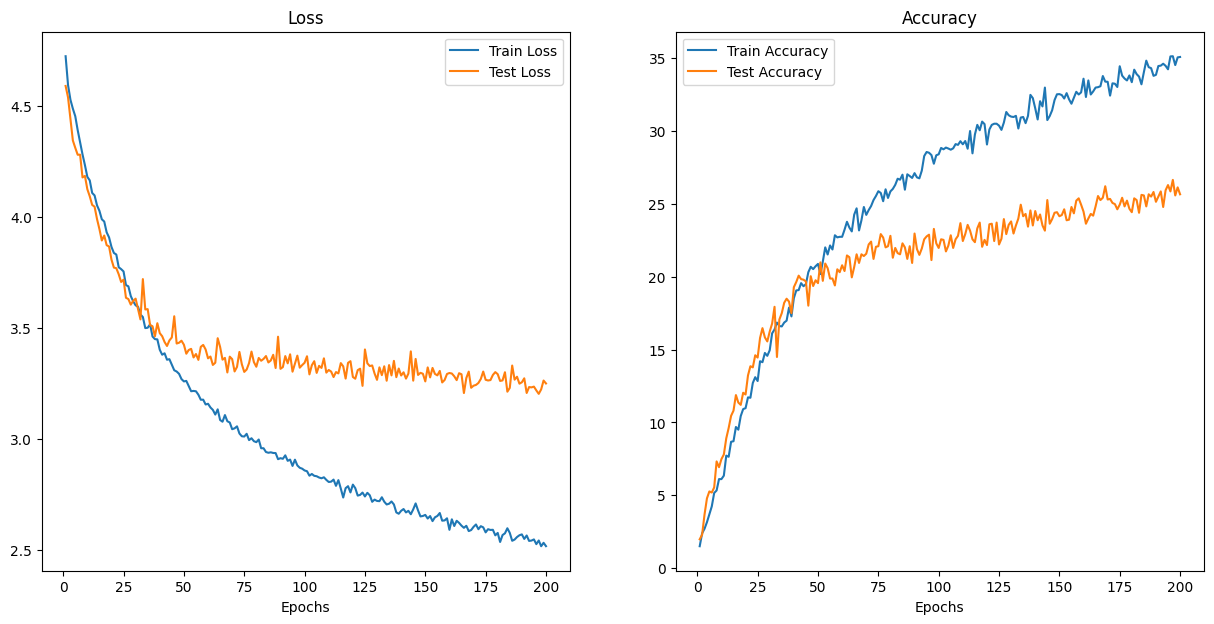

In [31]:
plot_model_lossacc(results_model_1)

#### 5.Creating a function to save the model

In [ ]:
%%writefile ../src/utils.py 
import os
import torch
import pandas as pd
from pathlib import Path
from typing import List,Dict
from datetime import datetime
from datetime import timedelta

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    ''' 
    Saves a PyTorch model to the target directory.
    Args:
        model: the model to be saved.
        target_dir: directory to save the model.
        model_name: A filename for the saved model, should include 
                    either ".pth" or ".pt" as their file_extension.
        
    '''
    # create target directory 
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                          exist_ok=True)
    
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth' " 
    model_save_path = target_dir_path / model_name

    torch.save(obj=model.state_dict(),
               f=model_save_path)

def upload_performance(model_name: str,
                       target_dir: str,
                       training_time: float,
                       model_results: Dict[str,List[int]]):
    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    formatted_training_time = str(timedelta(seconds=training_time))

    model_data = {
        "timestamp": timestamp,
        "model_name": model_name,
        "training_time": formatted_training_time,
        "epochs": len(model_results["test_acc"]),
        "test_accuracy": model_results["test_acc"][-1],
        "train_accuracy": model_results["train_acc"][-1],
    }
    print(model_data)
    
    # Convert to a DataFrame
    df = pd.DataFrame([model_data])
    print(df)

    # Append to CSV if it exists, otherwise create a new one
    target_path = target_dir + "performance_comparision.csv"
    
    if os.path.exists(target_dir):
        df.to_csv(target_path, mode='a', header=False, index=False)
    else:
        os.makedirs(target_dir,exist_ok=True)
        df.to_csv(target_path, mode='w', header=True, index=False)

    print("Model results saved successfully! 🚀")




Overwriting ../src/utils.py


#### 6. Creating train.py

In [75]:
%%writefile ../src/train.py

import torch 
from torch import nn 
from torchvision import transforms
from typing import List,Dict,Tuple

import engine, utils, transform
from models.TinyVGG import TinyVGGV1
from data_setup import create_dataloaders
from timeit import default_timer as timer

NUM_EPOCHS=150
BATCH_SIZE=25
NUM_WORKERS=1
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001
torch.cuda.manual_seed(42)

train_dir = f'../dataset/MiniFood101/train'
test_dir = f'../dataset/MiniFood101/test'

device = "cuda" if torch.cuda.is_available() else "cpu"

train_transform = transform.train_transform1
test_transform = transform.test_transform1

if __name__ == "__main__":
    
    train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                        test_dir=test_dir,
                                                                        train_transform=train_transform,
                                                                        test_transform=test_transform,
                                                                        batch_size=BATCH_SIZE,
                                                                        num_workers=NUM_WORKERS)

    model = TinyVGGV1(input_shape=3,
                    hidden_units=10,
                    output_shape=len(class_names)).to(device)

    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

    start_time = timer()
    model_results = engine.initiate_training(model=model,
                                            train_dataloader=train_dataloader,
                                            test_dataloader=test_dataloader,
                                            optimizer=optimizer,
                                            loss_fn=loss_fn,
                                            # scheduler=scheduler1,
                                            epochs=NUM_EPOCHS,
                                            device=device)       
    end_time = timer()

    model_training_time = end_time-start_time

    model_target_dir = '../models'
    utils.save_model(model=model,
                    target_dir=model_target_dir,
                    model_name='TinyVGGV1.pth')

    utils.upload_performance(model_name='TinyVGGV1',
                        target_dir='../model_performance/',
                        training_time= model_training_time,
                        model_results=model_results)



Overwriting ../src/train.py


#### Comparing both the models [IN PROGRESS]

In [ ]:
import pandas as pd

df1 = pd.DataFrame(results_model_0)
df2 = pd.DataFrame(results_model_1)

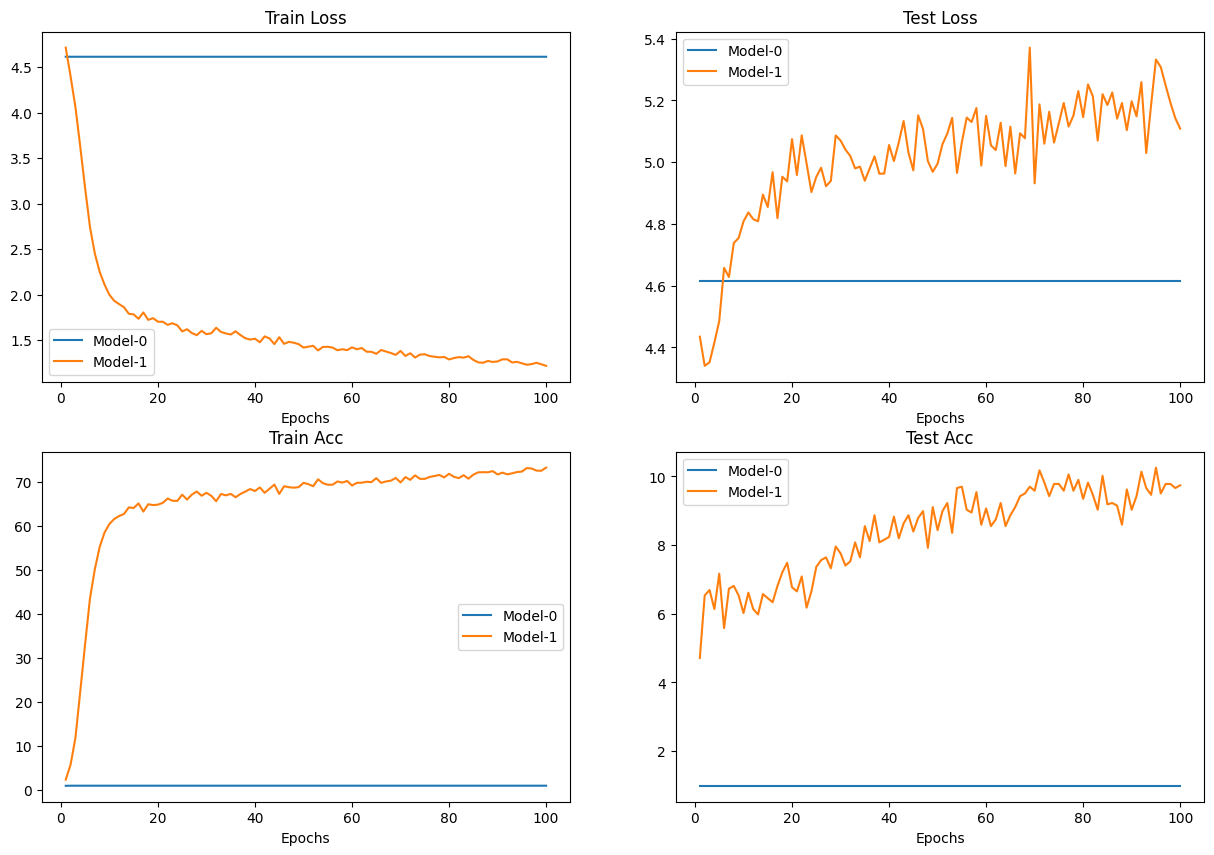

In [ ]:
# Setup the plot
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(df1['epoch_count'],df1['train_loss'],label="Model-0")
plt.plot(df2['epoch_count'],df2['train_loss'],label="Model-1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,2)
plt.plot(df1['epoch_count'],df1['test_loss'],label="Model-0")
plt.plot(df2['epoch_count'],df2['test_loss'],label="Model-1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,3)
plt.plot(df1['epoch_count'],df1['train_acc'],label="Model-0")
plt.plot(df2['epoch_count'],df2['train_acc'],label="Model-1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,4)
plt.plot(df1['epoch_count'],df1['test_acc'],label="Model-0")
plt.plot(df2['epoch_count'],df2['test_acc'],label="Model-1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend()

Lets see how to test new images, we will use read_image from torchvision to read custom images

In [ ]:
import torchvision 

custom_image_path = f"../dataset/Custom_Images/burger_1.jpg"
custom_image = torchvision.io.read_image(custom_image_path)

custom_image = custom_image.to(torch.float32)
custom_image = custom_image/255
print(custom_image.shape)

torch.Size([3, 408, 612])


Lets Make prediction on custom images

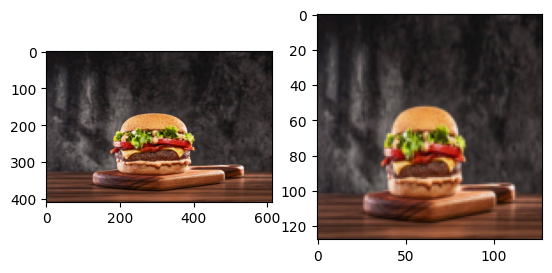

In [ ]:
# convert to uint8 to FloatTensor
custom_image_tranform = transforms.Compose([
    transforms.Resize(size=(128,128))
])

plt.subplot(1,2,1)
plt.imshow(custom_image.permute(1,2,0))
transformed_custom_image = custom_image_tranform(custom_image)
plt.subplot(1,2,2)
plt.imshow(transformed_custom_image.permute(1,2,0))

In [ ]:
model_1.eval()

with torch.inference_mode():
    y_pred_logits = model_1(transformed_custom_image.unsqueeze(0).to(device))

    y_pred = torch.argmax(y_pred_logits,dim=1)

    print(f"The output is: {class_names[y_pred]}")

    


The output is: bruschetta


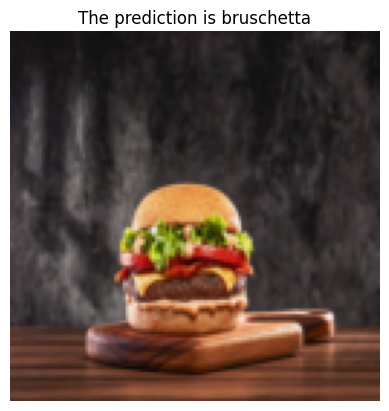

In [ ]:
def pred_and_plot_image(model: nn.Module,
                        image_path: str,
                        class_names: List[str],
                        transform=None,
                        device=device) -> None:
    
    target_image = torchvision.io.read_image(image_path).type(torch.FloatTensor)

    #divide the pixel to get range [0,1]
    target_image = target_image/255

    if transform:
        target_image = transform(target_image)
    
    model.to(device)
    model.eval()
    with torch.inference_mode():
        # extra dimension representing batch
        target_image = target_image.unsqueeze(0) 

        y_pred_logits = model(target_image.to(device))
        y_pred = torch.argmax(torch.softmax(y_pred_logits,dim=1),dim=1)

    plt.imshow(target_image.squeeze().permute(1,2,0).cpu())
    plt.title(f"The prediction is {class_names[y_pred]}")
    plt.axis('off')

pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_tranform,
                    device=device)